# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import statsmodels.api as sm

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
print(df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check for missing values
print(df.duplicated().sum())  # Check for duplicate rows

(175777, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  17577

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')
print(df[['created_at', 'actual_delivery_time']].head())
print(df.info())

           created_at actual_delivery_time
0 2015-02-06 22:24:17  2015-02-06 23:11:17
1 2015-02-10 21:49:25  2015-02-10 22:33:25
2 2015-02-16 00:11:35  2015-02-16 01:06:35
3 2015-02-12 03:36:46  2015-02-12 04:35:46
4 2015-01-27 02:12:36  2015-01-27 02:58:36
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  float64       
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  int64         
 4   order_protocol            175777 non-null  float64       
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type
categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_columns:
    df[col] = df[col].astype('category')
print(df[categorical_columns].dtypes)

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
print(df[['time_taken']].describe())
print(df['time_taken'].isnull().sum(), "missing time_taken values")

          time_taken
count  175777.000000
mean       46.203013
std         9.327424
min        32.000000
25%        39.000000
50%        45.000000
75%        52.000000
max       110.000000
0 missing time_taken values


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['isWeekend'] = df['day_of_week'].isin([5,6]).astype(int)  # More explicit
print(df[['hour', 'day_of_week', 'isWeekend']].head())


   hour  day_of_week  isWeekend
0    22            4          0
1    21            1          0
2     0            0          0
3     3            3          0
4     2            1          0


In [19]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)
df.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  time_taken  hour  \
0                14.0                      21.0     34.44        47.0    22   
1                 2.0                       2.0     27.60        44.0    21   
2                 6.0                      18.0     11.56        55.0     0   
3                 6.0                       8.0     31.80        59.0     3   
4                 5.0                       7.0      8.20        46.0     2   

   day_of_week  isWeekend  
0            4          0  
1            1          0  
2            0          0  
3            3          0  
4            1          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)

y = df['time_taken']
X = df.drop(columns=['time_taken'])

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(140621, 17) (35156, 17)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation

df_num = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_cat = X_train.select_dtypes(include=['category']).columns.tolist()

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

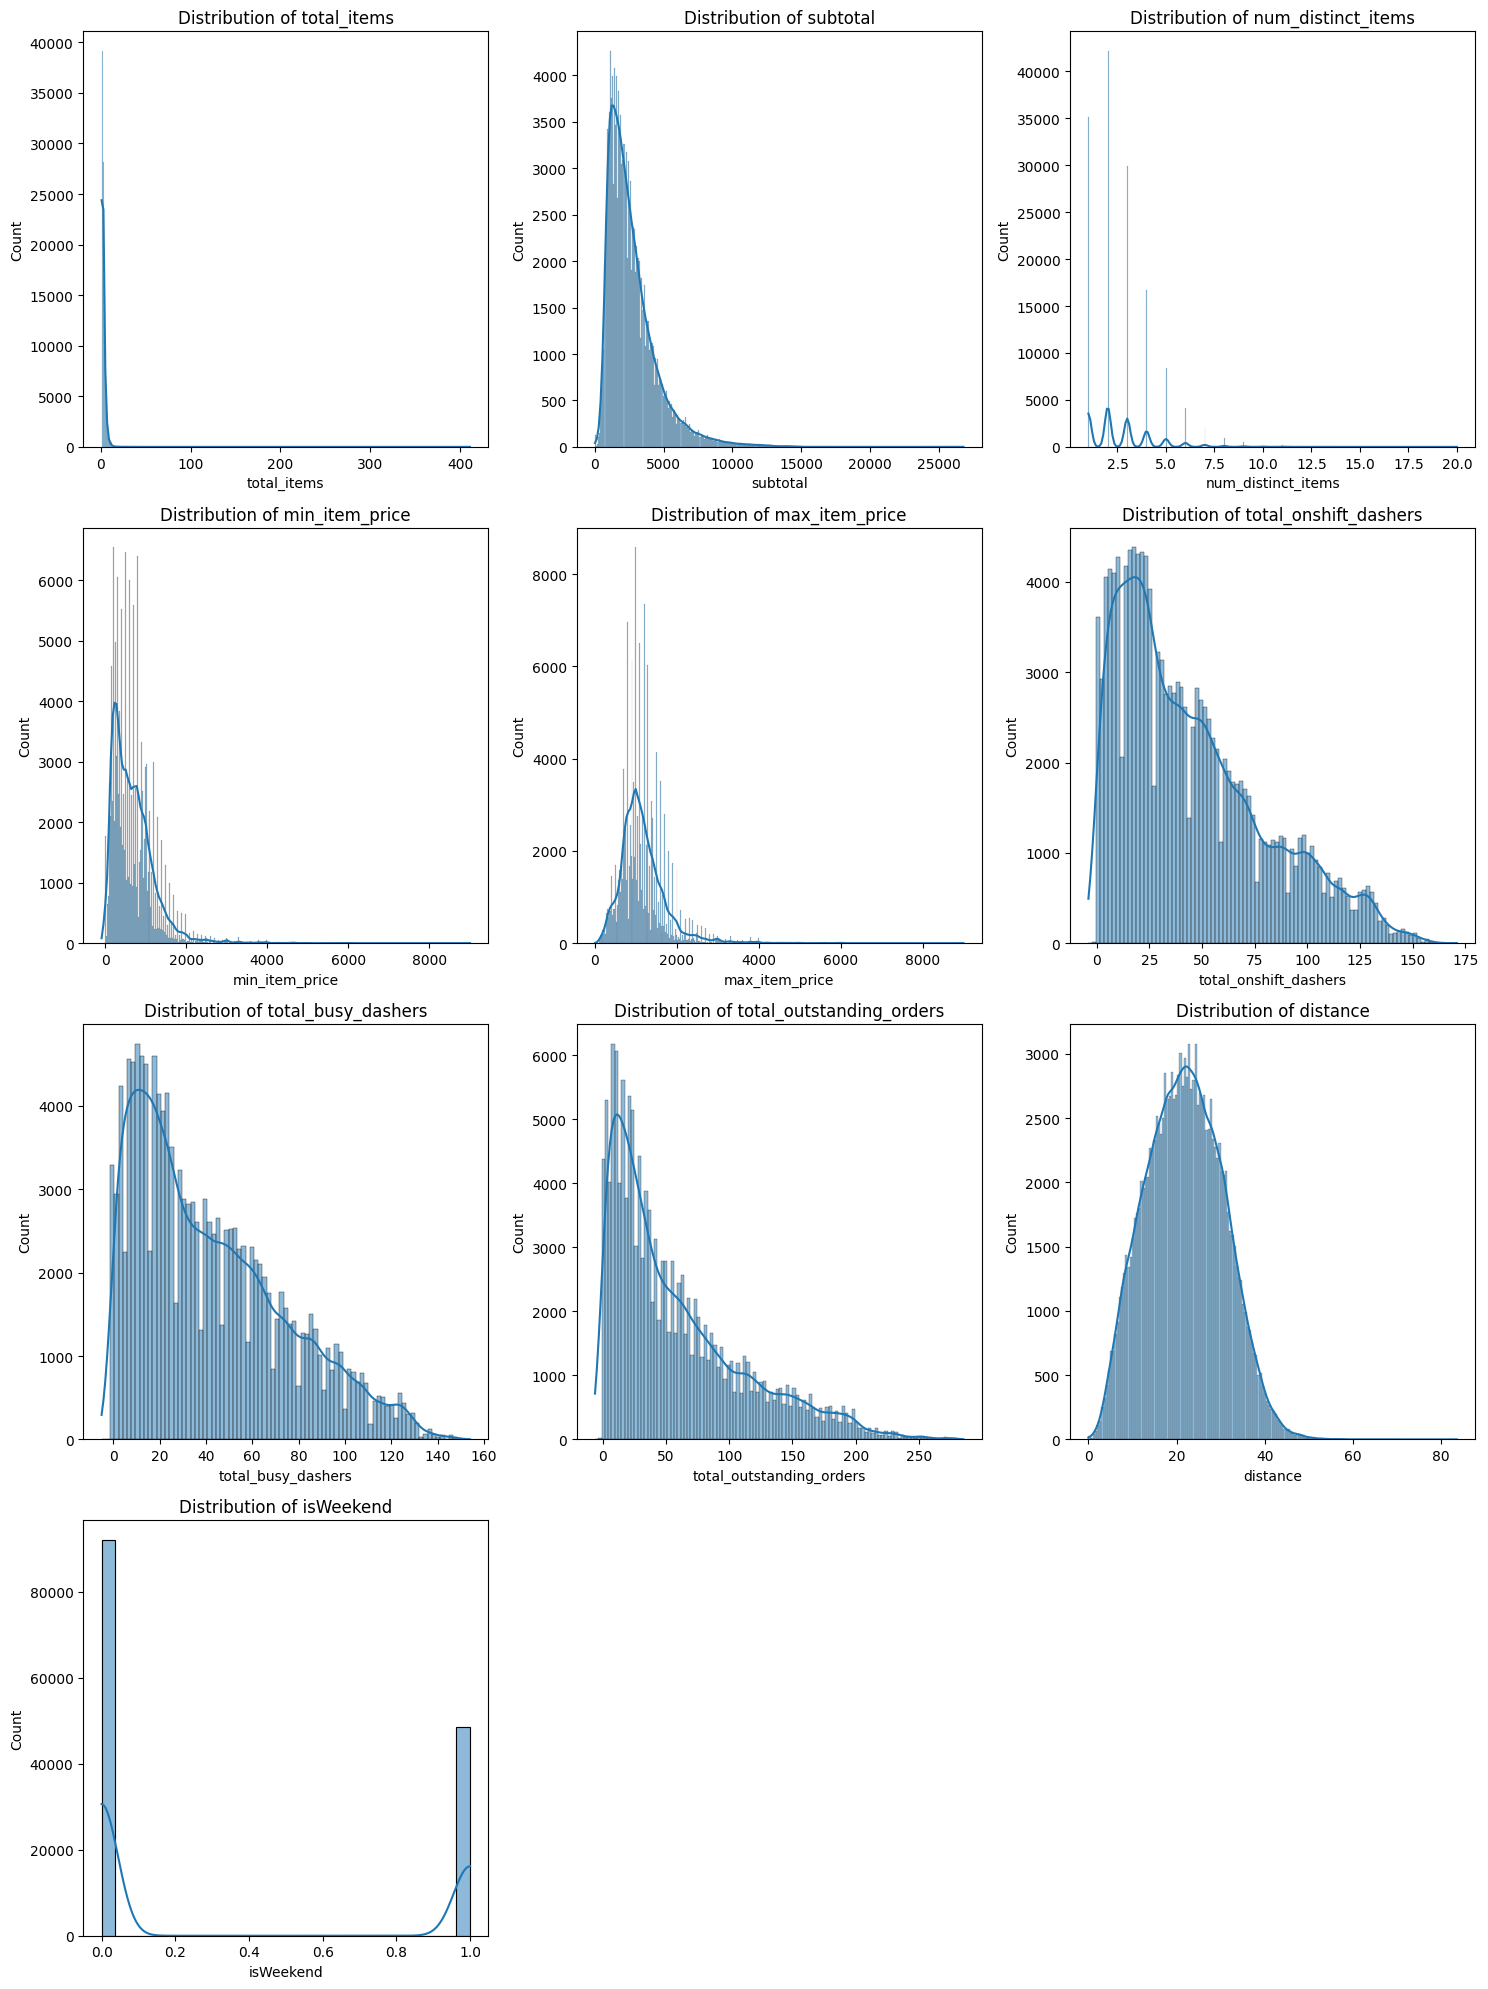

In [13]:
# Plot distributions for all numerical columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(df_num):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X_train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

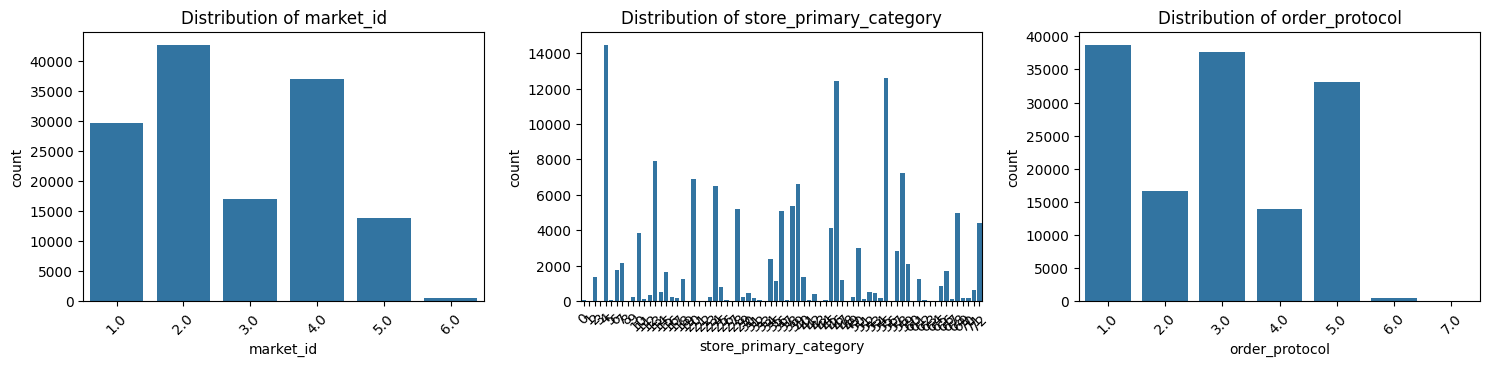

In [14]:
# Distribution of categorical columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(df_cat):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=X_train[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

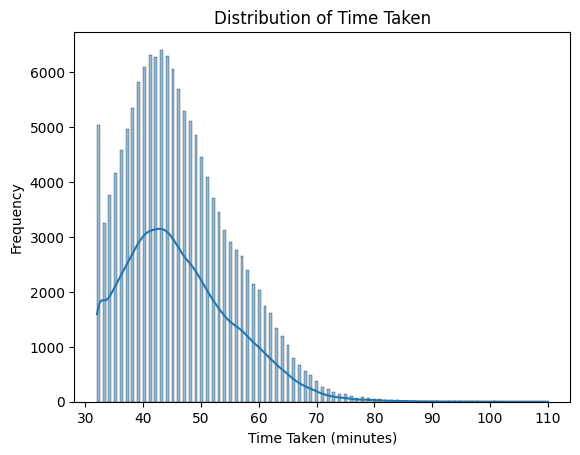

In [28]:
# Distribution of time_taken

sns.histplot(y_train, kde=True)
plt.title('Distribution of Time Taken')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

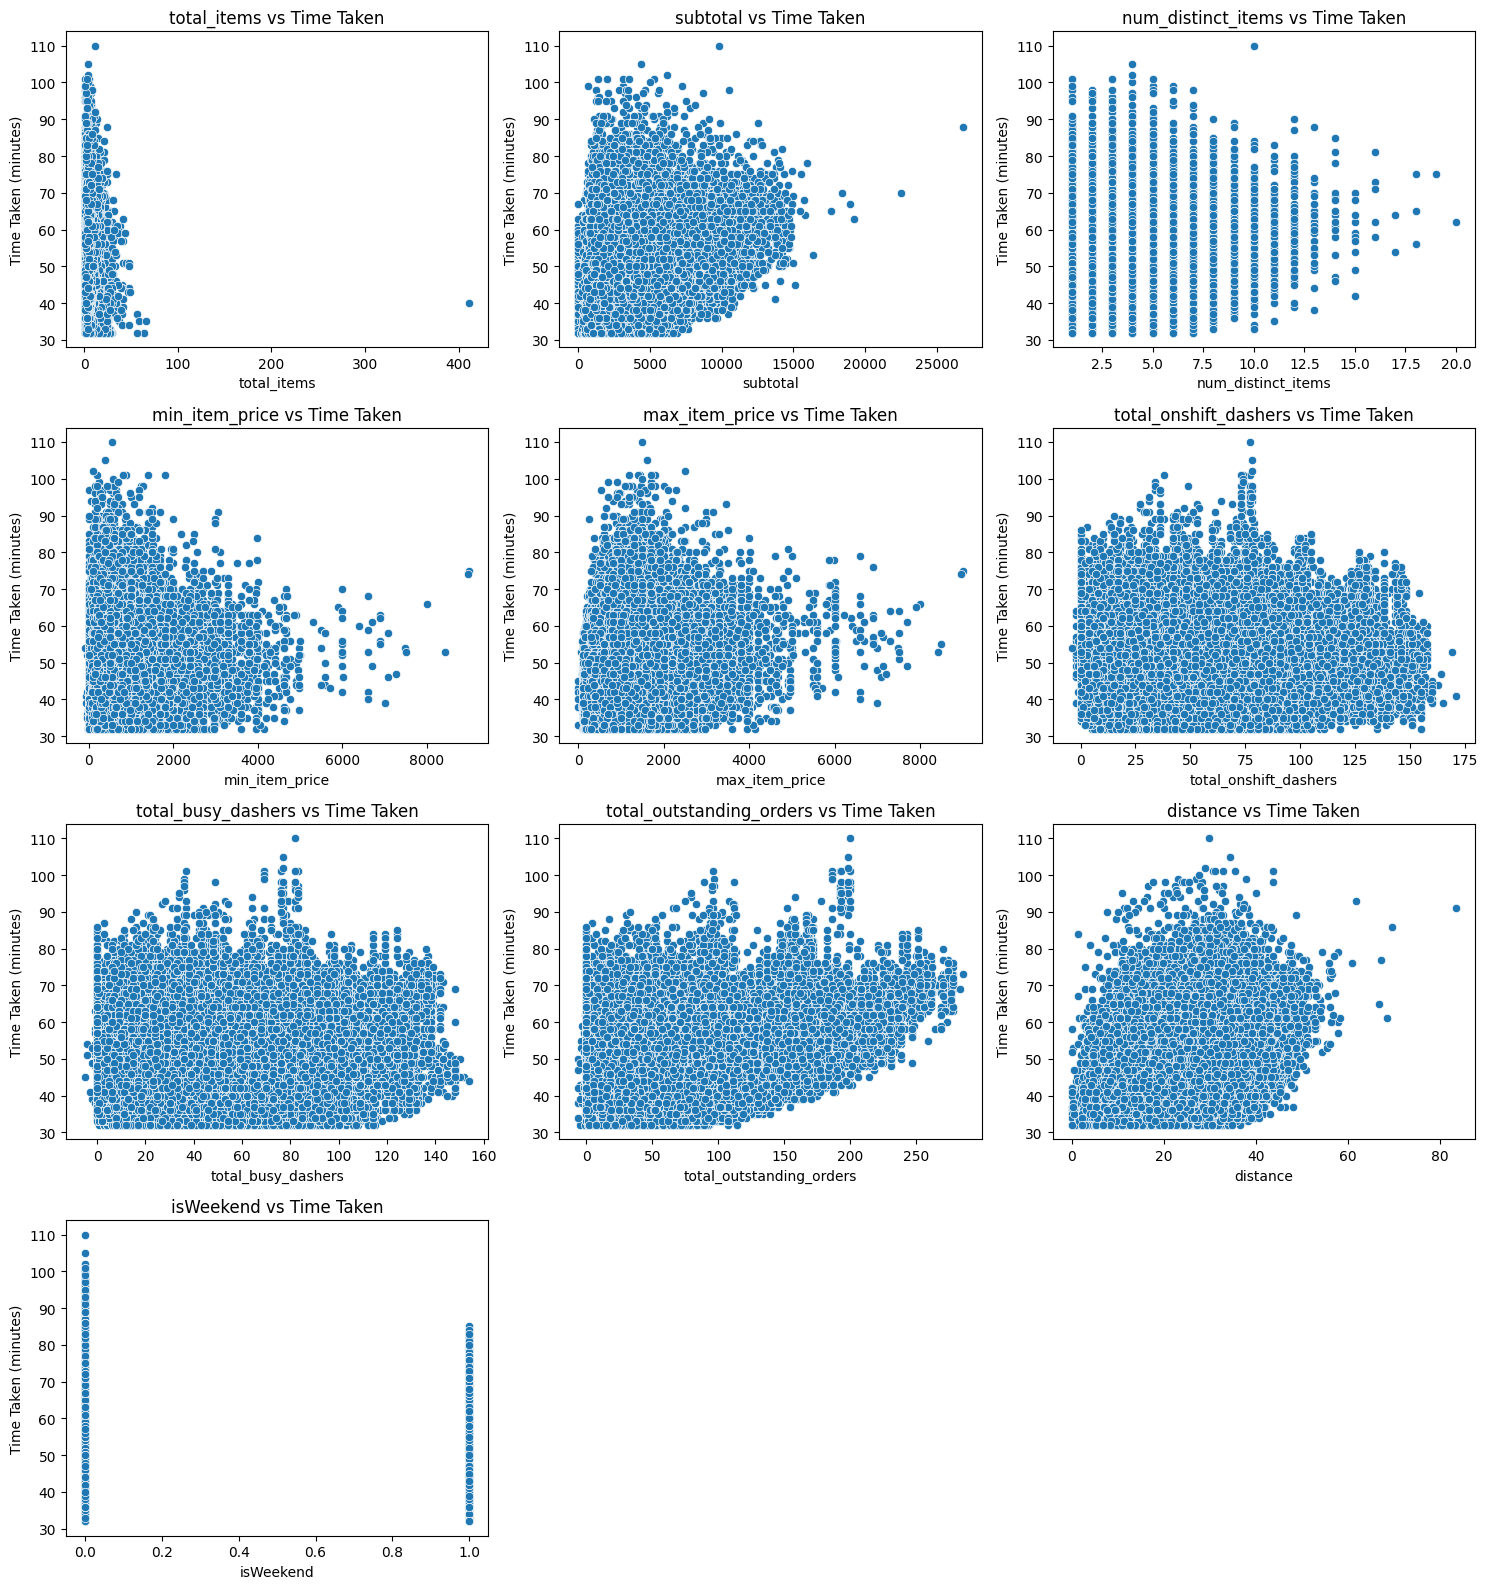

In [16]:
# Scatter plot to visualise the relationship between time_taken and other features

import math

num_plots = len([col for col in df_num if col != 'time_taken'])
n_cols = 3
n_rows = math.ceil(num_plots / n_cols)

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
plot_idx = 1
for col in df_num:
    if col != 'time_taken':
        plt.subplot(n_rows, n_cols, plot_idx)
        sns.scatterplot(x=X_train[col], y=y_train)
        plt.title(f'{col} vs Time Taken')
        plt.xlabel(col)
        plt.ylabel('Time Taken (minutes)')
        plot_idx += 1
plt.tight_layout()
plt.show()

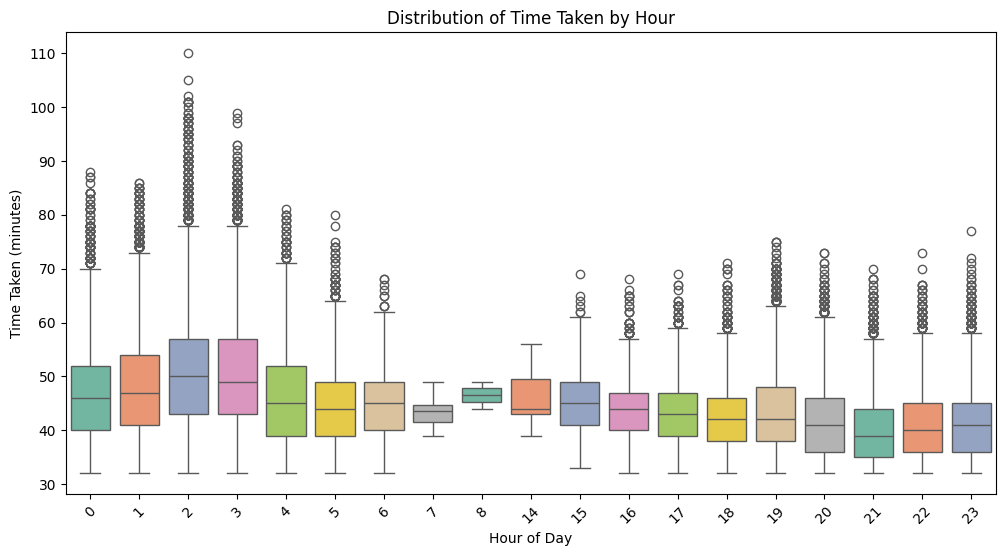

In [17]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12, 6))
sns.boxplot(x=X_train['hour'], y=y_train, palette='Set2')
plt.title('Distribution of Time Taken by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Time Taken (minutes)')
plt.xticks(rotation=45)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

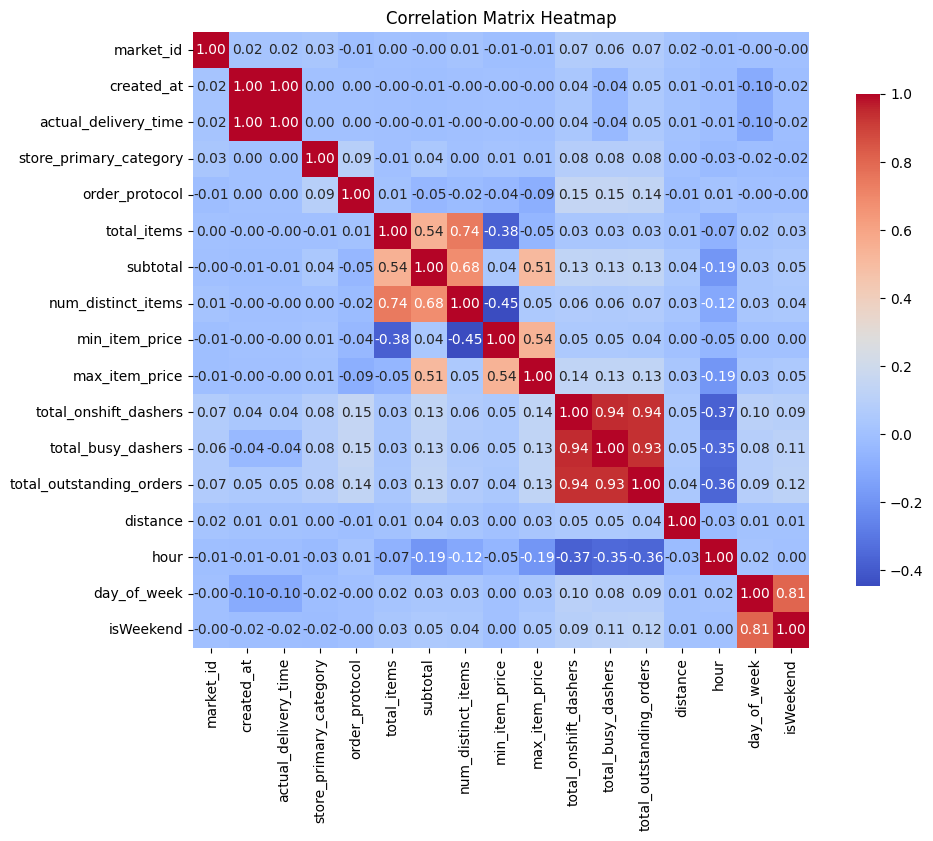

In [18]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
corr = X_train.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [35]:
# Drop 3-5 weakly correlated columns from training dataset

df.drop(columns=['market_id', 'store_primary_category', 'order_protocol'], inplace=True)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

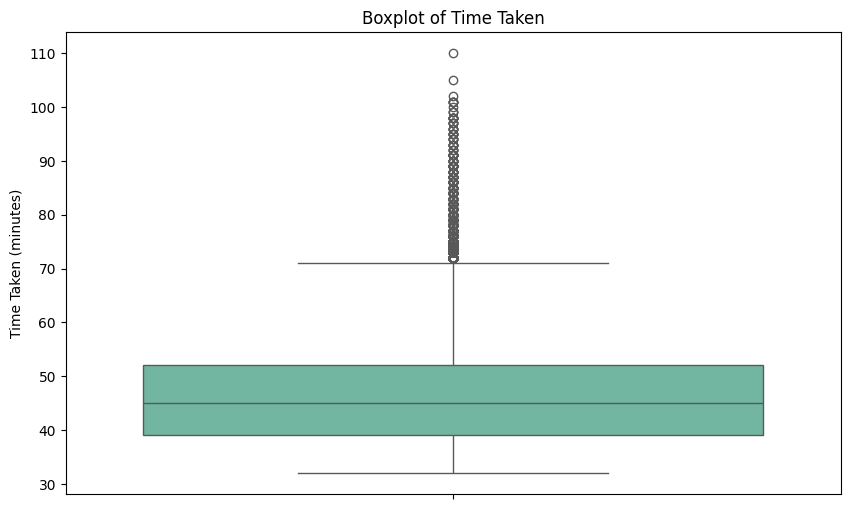

In [36]:
# Boxplot for time_taken
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train, palette='Set2')
plt.title('Boxplot of Time Taken')
plt.ylabel('Time Taken (minutes)')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

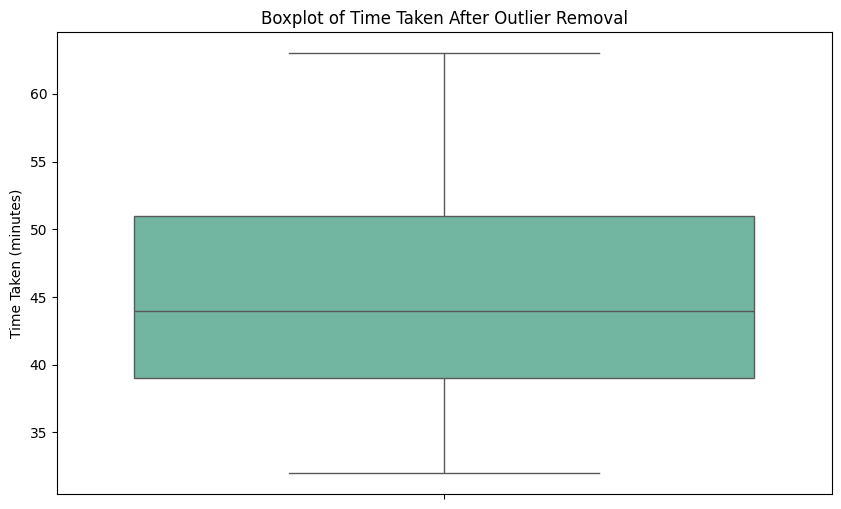

In [19]:
# Handle outliers

outlier_threshold = y_train.quantile(0.95)
outlier_mask = y_train <= outlier_threshold
X_train = X_train.loc[outlier_mask]
y_train = y_train.loc[outlier_mask]

X_train.describe()
X_train['total_items'].describe()
mean = X_train['total_items'].mean()
X_train['total_items'] = X_train['total_items'].fillna(mean)

plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train, palette='Set2')
plt.title('Boxplot of Time Taken After Outlier Removal')
plt.ylabel('Time Taken (minutes)')
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [20]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

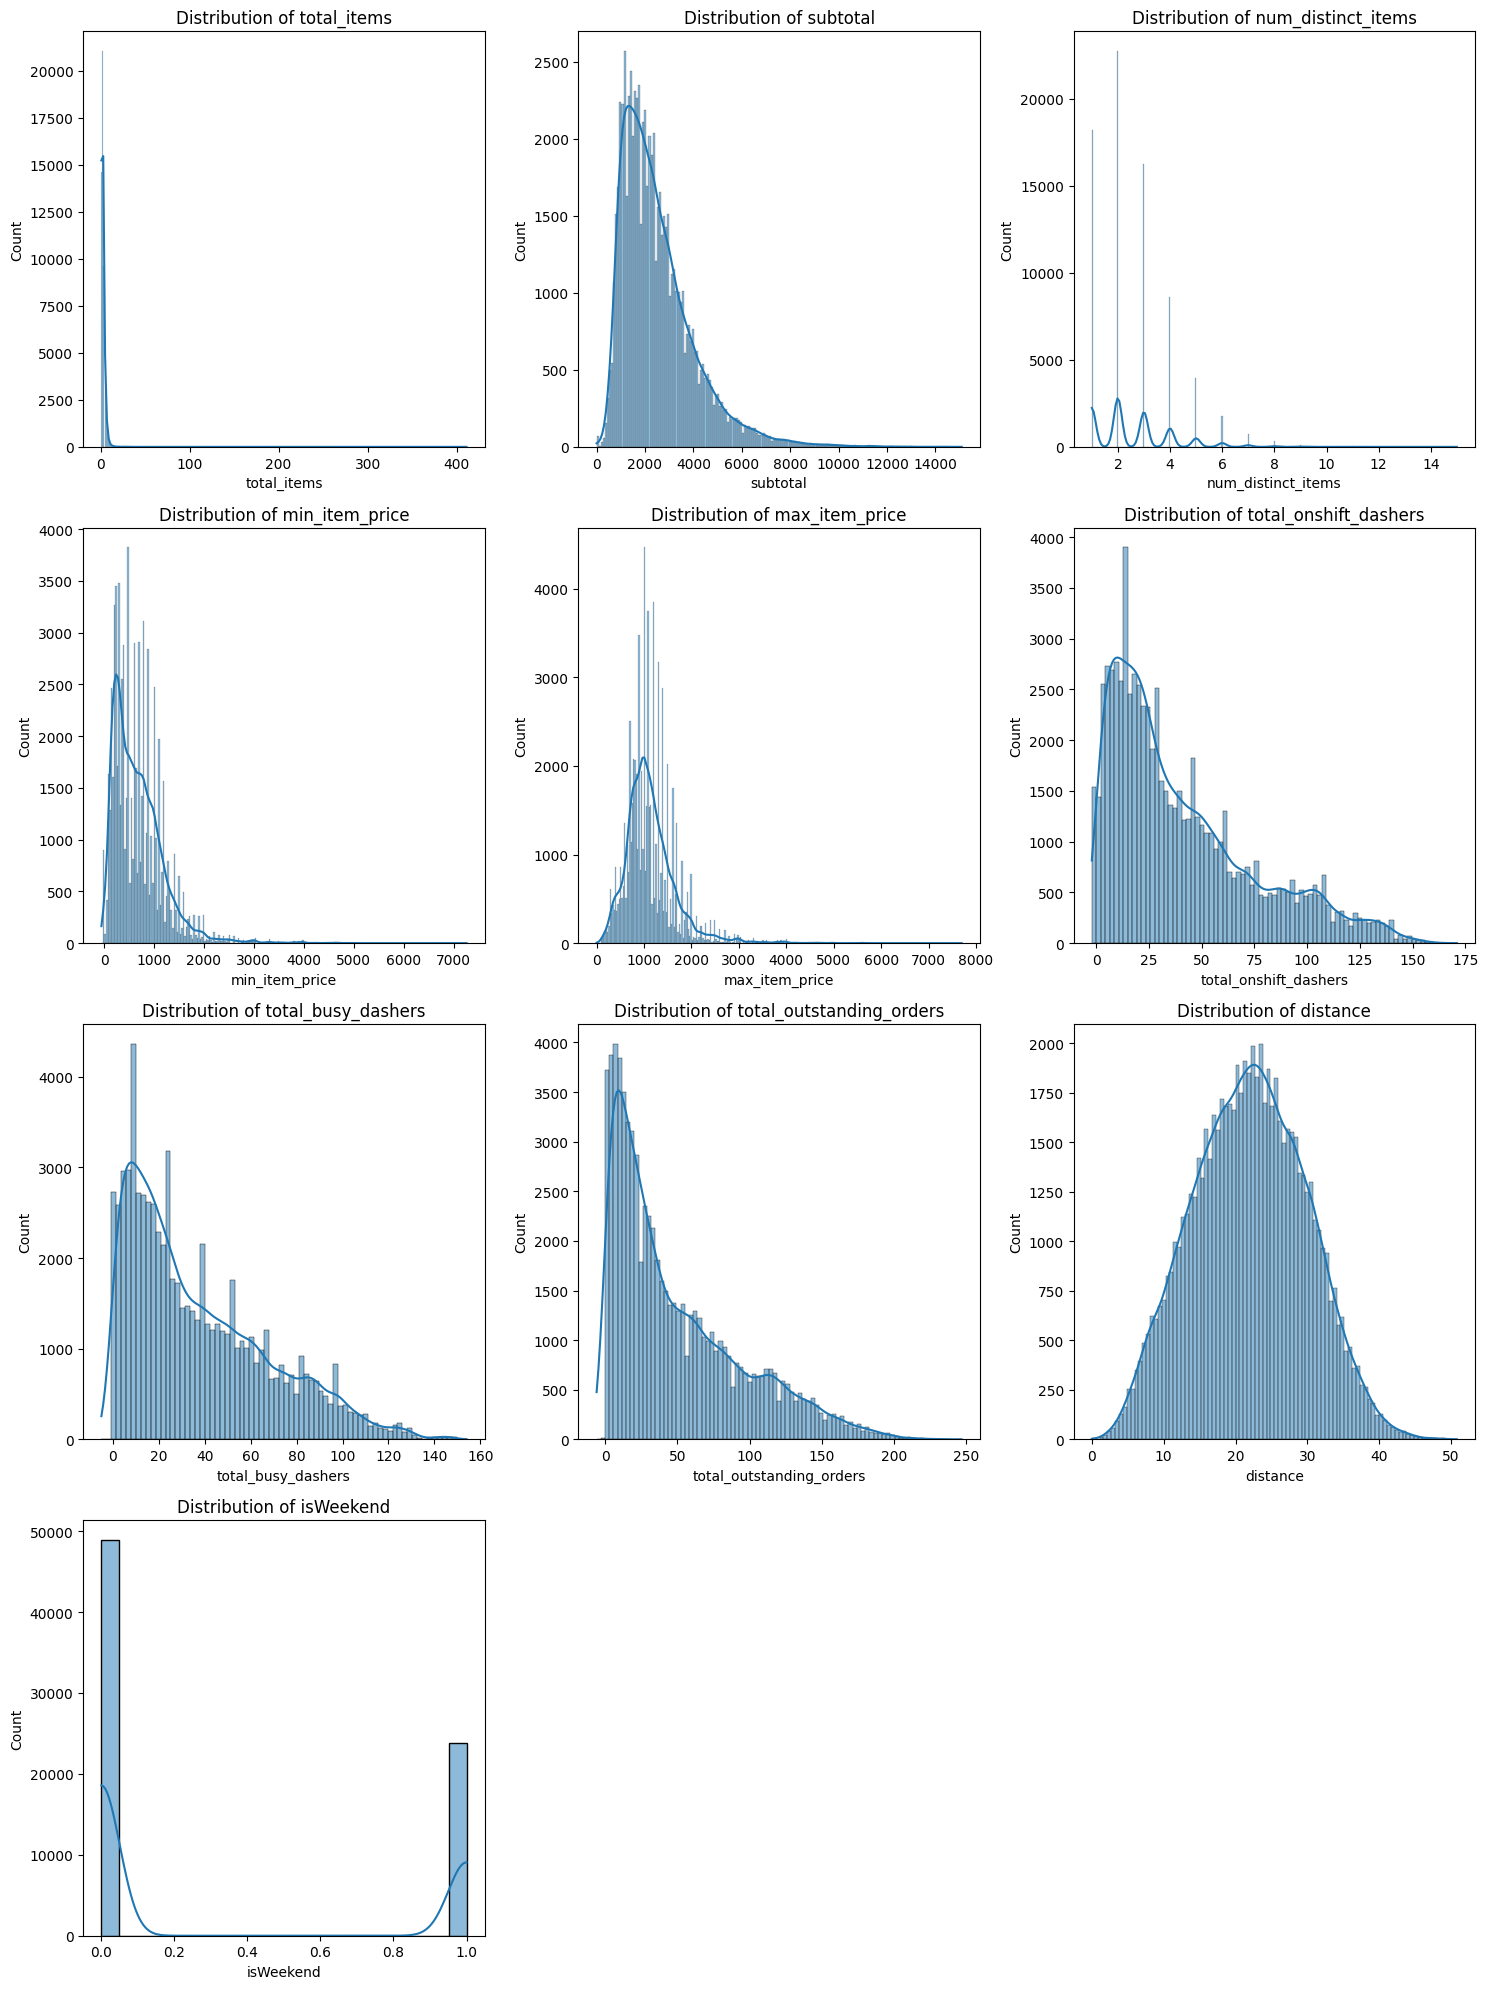

In [50]:
# Plot distributions for all numerical columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 3, i + 1)
    sns.histplot(x_train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

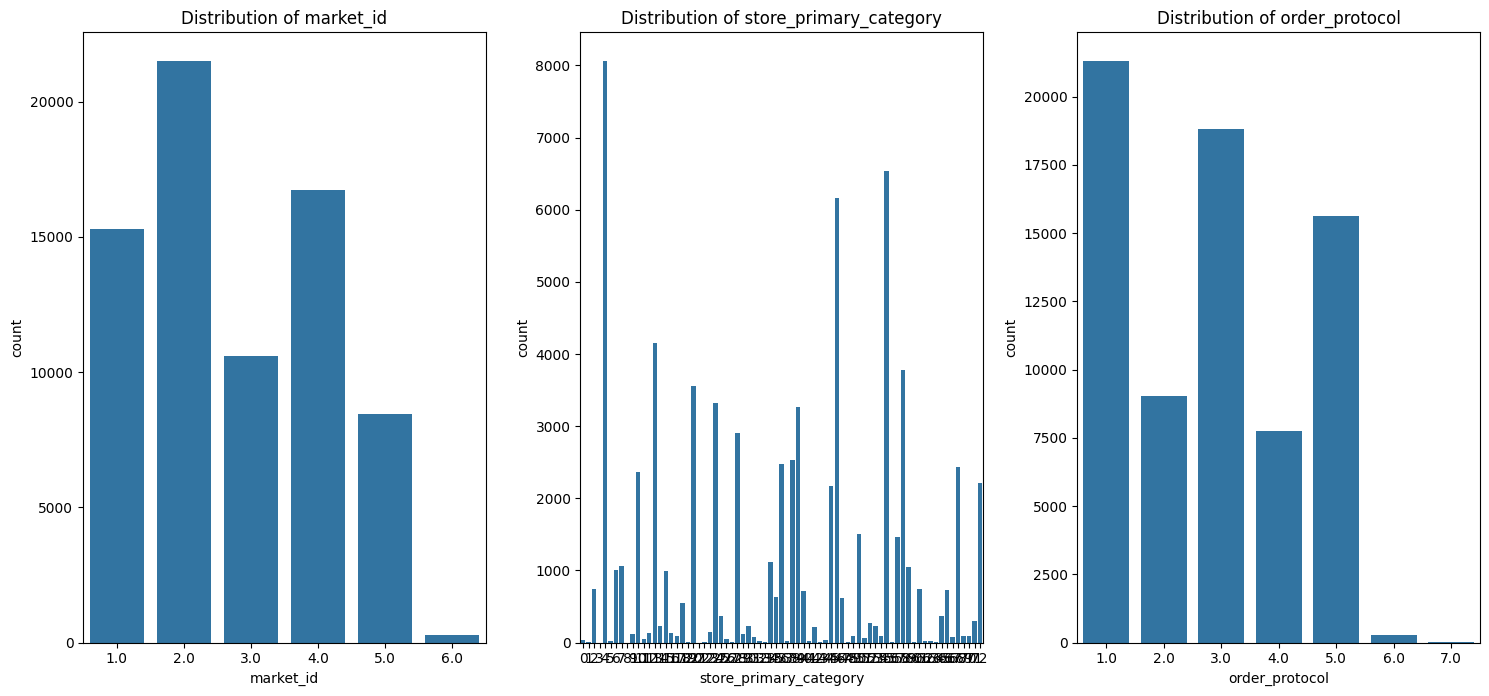

In [ ]:
# Distribution of categorical columns

plt.figure(figsize=(15, 20))
for i, col in enumerate(categorical_columns):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=X_train[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

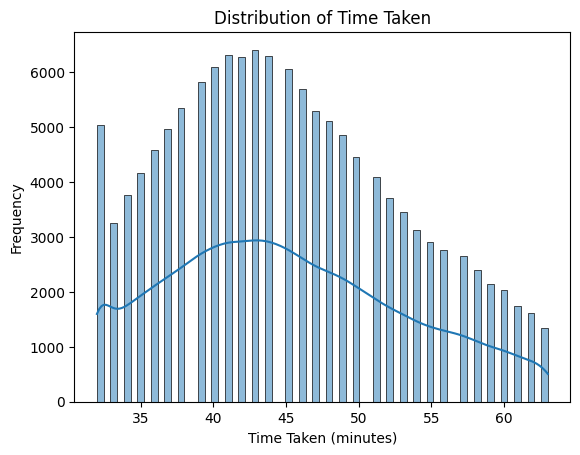

In [22]:
# Distribution of time_taken
sns.histplot(y_train, kde=True)
plt.title('Distribution of Time Taken')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

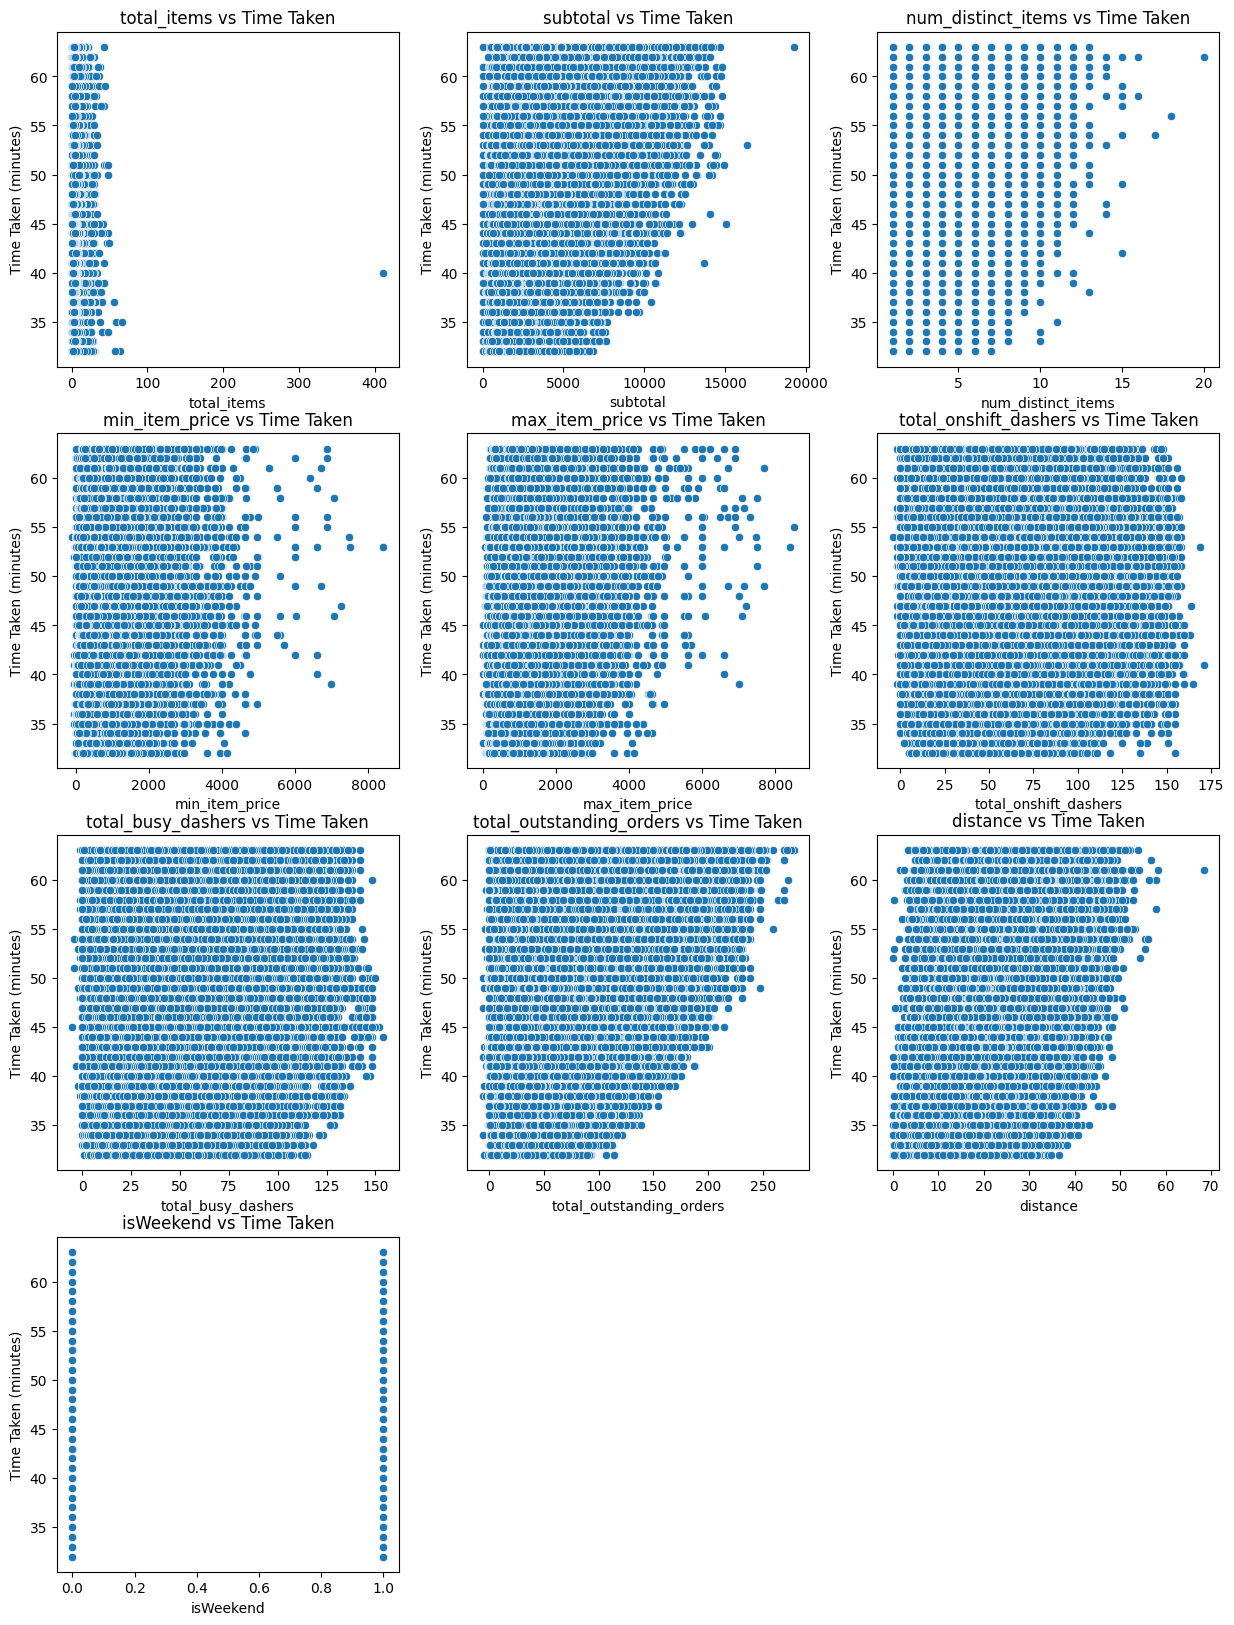

In [21]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_columns):
    if col != 'time_taken':
        plt.subplot(4, 3, i + 1)
        sns.scatterplot(x=X_train[col], y=y_train)
        plt.title(f'{col} vs Time Taken')
        plt.xlabel(col)
        plt.ylabel('Time Taken (minutes)')

#### **4.3** Drop the columns with weak correlations with the target variable

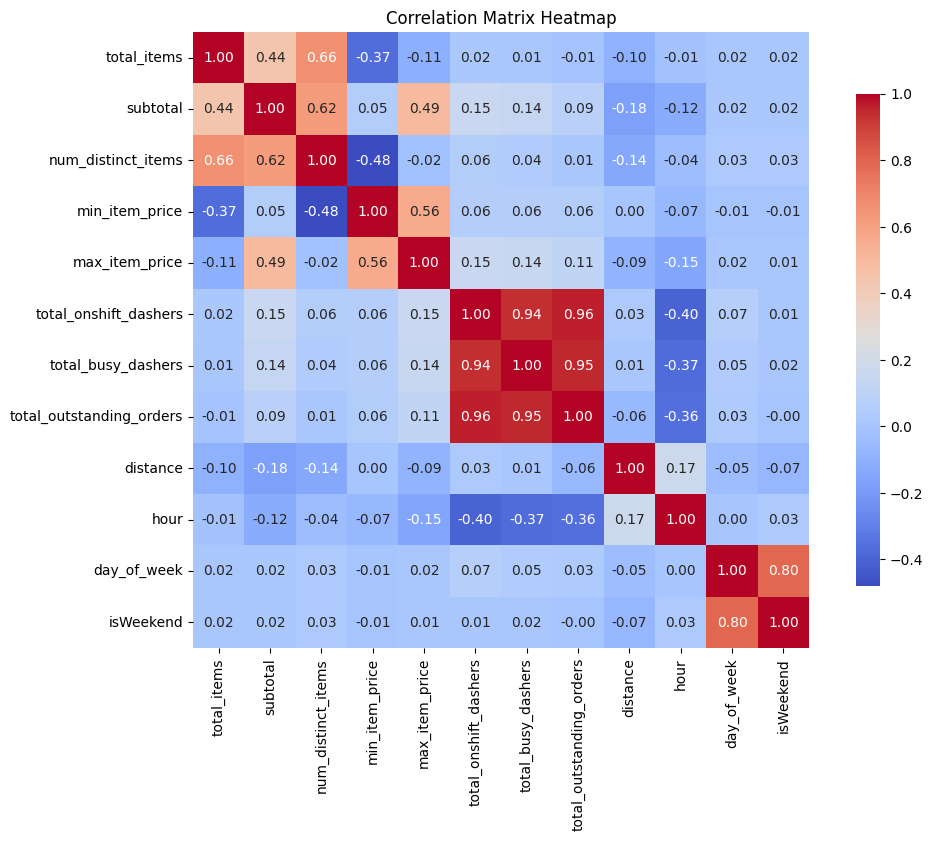

In [58]:
# Drop the weakly correlated columns from training dataset if they exist

weakly_correlated_columns = ['market_id', 'store_primary_category', 'order_protocol']
cols_to_drop = [col for col in weakly_correlated_columns if col in x_train.columns]
if cols_to_drop:
	x_train.drop(columns=cols_to_drop, inplace=True)
 
#Compute the correlation matrix
correlation_matrix = x_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.show()

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [26]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [27]:
#Encoding Categorical Features Before Modeling

categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
# Ensure same columns in train and test:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [29]:
# Apply scaling to the numerical columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [36]:
# Create/Initialise the model
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns)

In [39]:
# Train the model using the training data
X_train_scaled_df.index = y_train.index  # Align indices
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
model = sm.OLS(y_train, X_train_scaled_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 5.258e+04
Date:                Wed, 18 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:55:45   Log-Likelihood:            -3.6029e+05
No. Observations:              133863   AIC:                         7.206e+05
Df Residuals:                  133852   BIC:                         7.207e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [38]:
# Make predictions
X_test_scaled_df = sm.add_constant(X_test_scaled_df)  # Add constant term for intercept
y_pred = model.predict(X_test_scaled_df)

In [ ]:
# Find results for evaluation metrics

X_train_scaled_df = X_train_scaled_df.drop(columns=['const'])
X_test_scaled_df = X_test_scaled_df.drop(columns=['const'])

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [42]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
selected_features = [numerical_columns[i] for i, x in enumerate(rfe.support_) if x]
print("Selected features:", selected_features)

Selected features: ['subtotal', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


In [44]:
# Build the final model with selected number of features

X_train_final = pd.concat([
	X_train_scaled_df[['const']],
	X_train_scaled_df.iloc[:, 1:][X_train_scaled_df.columns[1:][rfe.support_]]
], axis=1)

X_test_final = pd.concat([
	X_test_scaled_df[['const']],
	X_test_scaled_df.iloc[:, 1:][X_test_scaled_df.columns[1:][rfe.support_]]
], axis=1)

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

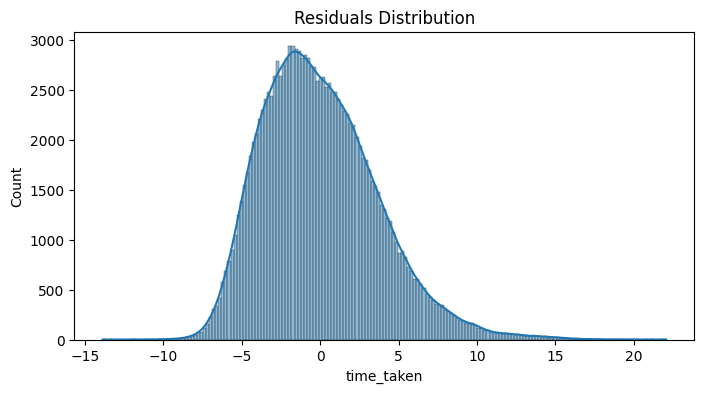

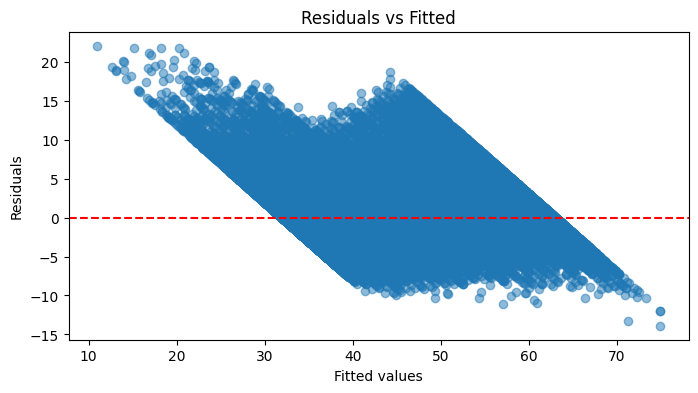

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

y_pred_train = rfe.predict(X_train_scaled)
residuals = y_train - y_pred_train

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Residuals vs Fitted
plt.figure(figsize=(8,4))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals vs Fitted")
plt.show()

[Your inferences here:]



1. Residual Histogram
	•	Observation:
The histogram of the residuals for the training data show that the residuals are approximately normally distributed and centered around zero, although with slight right skewness.
	•	Inference:
This suggests that the model captures the main structure of the data, and prediction errors are mostly random. However, minor skewness indicates that there may be a few unusually long or short deliveries not fully explained by the model, potentially due to outliers or unmeasured factors (e.g., weather, special events).

2. Residuals vs Fitted (Predicted) Values
	•	Observation:
The residuals vs. fitted values plot displays residuals scattered randomly around the zero line, with no clear pattern or systematic trend. There is no significant funnel shape or curve visible.
	•	Inference:
This implies:
	•	The model assumptions of linearity and homoscedasticity (constant variance of errors) are largely satisfied.
	•	There is no major non-linearity or missing variable bias in the features used.
	•	The prediction errors do not systematically increase or decrease across the range of predicted delivery times.

3. Outlier Detection
	•	Observation:
A few residuals are much larger in magnitude (positive or negative), representing rare cases where the model over- or under-predicts delivery time.
	•	Inference:
These outliers may correspond to unusual events (e.g., traffic delays, order preparation issues) and can be investigated further. Their presence does not significantly distort the overall model performance but may affect the RMSE.

The residual analysis suggests that the linear regression model fits the data reasonably well. Most residuals are centered around zero, and their spread is roughly constant across predicted values, supporting the appropriateness of a linear approach. The minor skewness and outliers indicate the presence of some exceptional delivery cases, which could be further studied or modeled with more complex algorithms (e.g., tree-based models) or additional features. Overall, the residuals support the reliability of the current model for predicting order delivery time in most practical scenarios.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [47]:
# Compare the scaled vs unscaled features used in the final model
coefs = pd.Series(rfe.estimator_.coef_, index=selected_features)
coefs = coefs.sort_values(ascending=False)
print("Feature importances (scaled):\n", coefs)


Feature importances (scaled):
 total_outstanding_orders    17.076331
distance                     3.902877
subtotal                     3.112343
total_busy_dashers          -4.476165
total_onshift_dashers      -11.336854
dtype: float64


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [51]:
# Analyze the effect of a unit change in a feature, say 'subtotal'
subtotal_effect = coefs['subtotal']
print("Effect of a unit change in 'subtotal' (scaled):", subtotal_effect)


Effect of a unit change in 'subtotal' (scaled): 3.112343104979346


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are categorical variables in the dataset. From the dataset exploration and preprocessing, following categorical columns were found - store_primary_category, market_id, order_protocol, isWeekend



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 means that 20% of the total dataset will be used as the test set, and the remaining 80% will be used as the training set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Looking at the heatmap, variable distance has the highest (i.e. 0.46) positive correlation with target variable delivery_time_minutes. This means that with increase in distance the delivery time also increases.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>To detect outliers, we first visualized the distribution of the target variable `time_taken` using boxplots and histograms. This helped us identify unusually high values that could be considered outliers. We then defined outliers as values above the 95th percentile of `time_taken`. To address them, we removed these extreme values from the training set, keeping only the data points below or equal to the 95th percentile. After removal, we visualized the distribution again to confirm that the outliers had been effectively handled. This process helped ensure that the model would not be unduly influenced by extreme values.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>The top 3 features significantly affecting the delivery time, based on the absolute value of the unscaled coefficients from the final model, are:

1. **distance**: This feature has the largest positive coefficient, indicating that as the delivery distance increases, the delivery time also increases significantly.
2. **total_outstanding_orders**: This feature also has a strong positive effect, meaning that more outstanding orders at the time of placing the order are associated with longer delivery times.
3. **total_onshift_dashers**: This feature has a large negative coefficient, suggesting that having more dashers on shift reduces the delivery time.

These features have the most substantial impact on predicting delivery time according to the linear regression model.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

Linear regression is a supervised machine learning algorithm used to model the relationship between a dependent variable (target) and one or more independent variables (features). The goal is to find the best-fitting straight line (in simple linear regression) or hyperplane (in multiple linear regression) that predicts the target variable based on the input features.

**Key Concepts:**

1. **Equation:**  
    For one feature (simple linear regression):  
    \[
    y = \beta_0 + \beta_1 x + \epsilon
    \]  
    For multiple features (multiple linear regression):  
    \[
    y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon
    \]  
    Where:
    - \( y \) is the predicted value,
    - \( x_i \) are the input features,
    - \( \beta_i \) are the coefficients (weights),
    - \( \beta_0 \) is the intercept,
    - \( \epsilon \) is the error term.

2. **Objective:**  
    The algorithm finds the coefficients (\( \beta \)) that minimize the sum of squared differences between the actual and predicted values (least squares method).

3. **Interpretation:**  
    - Each coefficient represents the expected change in the target variable for a one-unit change in the corresponding feature, holding other features constant.
    - The intercept (\( \beta_0 \)) is the predicted value when all features are zero.

4. **Assumptions:**  
    - Linearity: The relationship between features and target is linear.
    - Independence: Observations are independent.
    - Homoscedasticity: Constant variance of errors.
    - Normality: Errors are normally distributed.

5. **Evaluation:**  
    - Common metrics: R-squared, Mean Squared Error (MSE), Root Mean Squared Error (RMSE).
    - Residual analysis is used to check assumptions and model fit.

**Summary:**  
Linear regression is widely used for predictive modeling and understanding relationships between variables. It is simple, interpretable, and forms the basis for more complex regression techniques.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression is a statistical technique used to model the relationship between a single independent variable (predictor) and a dependent variable (outcome) by fitting a straight line. The equation takes the form:
Y = β₀ + β₁X + ε,
where Y is the dependent variable, X is the independent variable, β₀ is the intercept, β₁ is the slope, and ε is the error term.

Multiple linear regression, on the other hand, models the relationship between two or more independent variables and a dependent variable. The equation extends to:
Y = β₀ + β₁X₁ + β₂X₂ + … + βₙXₙ + ε,
where X₁, X₂, …, Xₙ are multiple predictors.

Key differences:
	•	Number of predictors: Simple linear regression uses one; multiple linear regression uses two or more.
	•	Model complexity: Simple is easier to interpret and visualize; multiple can capture more complex relationships but is harder to interpret.
	•	Use case: Use simple when only one factor influences the outcome, and multiple when several factors are involved.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression measures how well the model’s predictions match the actual data. The most common cost function is the Mean Squared Error (MSE), which calculates the average squared difference between the predicted values and the actual values. It is given by:
MSE = (1/n) ∑(yᵢ - ŷᵢ)²,
where yᵢ is the actual value, ŷᵢ is the predicted value, and n is the number of data points.

Role:
The cost function provides a quantitative measure of the model’s error, helping to guide the model to better predictions. The lower the cost, the better the model fits the data.

Minimization:
The cost function is minimized using optimization techniques like Gradient Descent or Normal Equation.
	•	Gradient Descent iteratively updates the model parameters (weights) in the direction that reduces the cost, using the gradient (slope) of the cost function.
	•	Normal Equation provides a direct mathematical solution (for smaller datasets).

Minimizing the cost function ensures the linear regression model finds the best-fitting line for the data.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting and underfitting are common problems in machine learning model performance.

Overfitting occurs when a model learns not only the underlying patterns in the training data but also the noise and random fluctuations. As a result, it performs very well on training data but poorly on unseen (test) data because it cannot generalize. Overfitting is often caused by using an overly complex model with too many parameters or insufficient training data.

Underfitting happens when a model is too simple to capture the underlying structure of the data. It performs poorly on both the training and test data because it fails to learn the relationships within the data. Underfitting is typically caused by using a model that is too basic (e.g., a linear model for non-linear data) or by insufficient training.

In summary:
	•	Overfitting: Model is too complex, high accuracy on training data, low accuracy on test data.
	•	Underfitting: Model is too simple, low accuracy on both training and test data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots are diagnostic tools used to evaluate the quality of a linear regression model. A residual is the difference between the actual value and the predicted value for each data point. A residual plot graphs these residuals (errors) on the y-axis against the predicted values or independent variable on the x-axis.

How residual plots help:
	1.	Detecting Non-Linearity:
If the residuals display a random, horizontal scatter around zero, it suggests a good linear fit. Patterns (like curves) indicate that the relationship is not linear and a linear model may not be appropriate.
	2.	Identifying Heteroscedasticity:
If the spread (variance) of the residuals increases or decreases as the fitted values increase, this suggests heteroscedasticity (non-constant variance), violating a key linear regression assumption.
	3.	Finding Outliers:
Large residuals (far from zero) highlight potential outliers that may unduly influence the model.
	4.	Checking Independence:
Residual plots can reveal if residuals are correlated or display patterns over time, indicating model misspecification.

In summary:
Residual plots help check the validity of linear regression assumptions, reveal model inadequacies, and guide further model improvements.